<a href="https://colab.research.google.com/github/ChenZhenY/Artistic-Style-Transfer/blob/main/Raceline_Generation(Documentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Before continuing, make a copy of this notebook for personal use so that this one can be continued to be shared to others. Thanks!

### Install and import libraries

In [ ]:
!pip install navpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.pyplot import figure
import navpy
from scipy import interpolate
import plotly.express as px
import plotly.graph_objects as go
import json
import ipywidgets as widgets
from IPython.display import display
from cProfile import label
from cmath import sqrt
from typing import List
import cmath

from google.colab import output
output.enable_custom_widget_manager()

### Functions

Run through and load all the functions in this section, they will be used later during the generation parts. Take note of comments in the conversion from LTP to Lat-Long (and vice versa) as some changes may need to be made depending on certain given csv inputs. Most of these is flipping x-y or lat-long coordinates and is done after generating an output. That is to say, if the output is incorrect (usually flipped or mirrored in some way), then you would go back and adjust the x-y or lat-long values in the function.

Make sure the origin coordinates in the ltp->lla or lla->ltp are the correct ones for the corresponding track.

In [ ]:
#create boundary offset

#takes in arguments of x-coords, y-coords, and offset distance (m)
def offset(xx, yy, d):

  xN = []
  yN = []

  d=d 

  for i in range(len(xx)-1):

    r = np.sqrt((xx[i+1]-xx[i])**2+(yy[i+1]-yy[i])**2)
    dx = d/r*(yy[i]-yy[i+1])
    dy = d/r*(xx[i+1]-xx[i])

    xN.append(xx[i]+dx)
    yN.append(yy[i]+dy)
  
  return xN, yN

In [ ]:
#convert from Lat-Long to LTP

#origin
lat0 = 36.268252
long0 = -115.015914

#csv columns seperated by ',' as delimiter 
def convert_ltp(csv_name):

  traj_df = pd.read_csv(csv_name, names=['Lat','Lon','Type'])

  #may need to flip lat-long columns depending on CSV
  traj_2D_list = navpy.lla2ned(lat=traj_df.iloc[:, 0],lon=traj_df.iloc[:, 1], 
                              alt=[0]*len(traj_df.iloc[:,0]), lat_ref=lat0, 
                              lon_ref=long0, alt_ref=0, latlon_unit='deg')
  
  return traj_2D_list


#csv columns seperated by white space (' ') as delimiter
def convert_ltp_ws(csv_name):
  traj_df = pd.read_csv(csv_name, names=['Lat','Lon','Type'], delim_whitespace=True)

  traj_2D_list = navpy.lla2ned(lat=traj_df.iloc[:, 0],lon=traj_df.iloc[:, 1], 
                              alt=[0]*len(traj_df.iloc[:,0]), lat_ref=lat0, 
                              lon_ref=long0, alt_ref=0, latlon_unit='deg')
  return traj_2D_list

In [ ]:
#convert from LTP to Lat-Long

#origin
lat0 = 36.268252
long0 = -115.015914

def convert_latlong(csv_name):

  traj_df = pd.read_csv(csv_name, names=['x', 'y'], delim_whitespace=True)
  traj_df['z'] = 0 #add column of zeros for z-coord
  
  #may be needed to flip the axis on latlong
  traj_df['y'] = traj_df['y'].apply(lambda x: x*-1)

  #results in 3 rows of lat, lon, lat
  traj_2D_list = navpy.ned2lla(ned=traj_df, lat_ref=lat0, lon_ref=long0, alt_ref=0,
                               latlon_unit='deg')
  

  traj_2D_list =  list(zip(*traj_2D_list)) #transpose to 3 columns of lat, lon, alt

  traj_2D_list = pd.DataFrame(traj_2D_list, columns=['lat', 'lon', 'alt']) #convert to pandas dataframe
  
  return traj_2D_list

#incase x and y are flipped
def convert_latlong_flip(csv_name):

  traj_df = pd.read_csv(csv_name, names=['y', 'x'], delim_whitespace=True)
  traj_df = traj_df[['x', 'y']]
  traj_df['z'] = 0 #add column of zeros for z-coord

  #results in 3 rows of lat, lon, lat
  traj_2D_list = navpy.ned2lla(ned=traj_df, lat_ref=lat0, lon_ref=long0, alt_ref=0,
                               latlon_unit='deg')
  

  traj_2D_list =  list(zip(*traj_2D_list)) #transpose to 3 columns of lat, lon, alt

  traj_2D_list = pd.DataFrame(traj_2D_list, columns=['lat', 'lon', 'alt']) #convert to pandas dataframe
  
  return traj_2D_list

In [ ]:
#smooths generated spline line

def smoother(xx, yy):

  x = np.asarray(xx)
  y = np.asarray(yy)

  #create spline function
  #k is the degree of function
  #s is the amount of smoothness
  f, u = interpolate.splprep([x, y], k=3, s=0.1, per=True)
  
  #create interpolated lists of points
  xint, yint = interpolate.splev(np.linspace(0, 1, 9500), f)
  #plt.scatter(x, y)
  #plt.plot(xint, yint)
  #plt.show()

  # calculate total distance of spline
  spline_d = dist_tot(xint, yint)

  #rediscretize points to be ~1m apart from each other
  xint, yint = interpolate.splev(np.linspace(0, 1, int(spline_d)), f)

  #combine and transpose to be 2 columns
  combined = np.vstack((xint, yint)).T

  return combined, xint, yint

In [ ]:
#calculate total distance

def dist_tot(xx, yy):
  
  d = 0

  for i in range(len(xx)-1):
    di = np.sqrt((xx[i]-xx[i+1])**2 + (yy[i]-yy[i+1])**2)
    d+=di

  return d

In [ ]:
#calculate closest 2 points to a third

def closest_point(point, point_listx, point_listy):

  min_dist = float('inf')
  min_idx = 0

  if len(point_listx)<2:
    return len(point_listx)

  x = point[0]
  y = point[1]

  for i in range(len(point_listx)-1):
    x1, y1 = point_listx[i], point_listy[i]
    x2, y2 = point_listx[i+1], point_listy[i+1]

    dist = np.sqrt((x-x1)**2 + (y-y1)**2) + np.sqrt((x-x2)**2 + (y-y2)**2)
    
    if dist<min_dist:
      min_idx = i
      min_dist = dist
    
  
  return min_idx+1



### Load in LVMS lines

Below is loading in csv's that are in LTP. csv is read and converted to pandas dataframe with column names 'x' and 'y'. Depending on what the delimiter seperating the whitespaces are, additional parameters may need to be added. To load in a csv, simply drag the csv in the files tab on the left side of Google Colab (if using Google colab) and load in using the correct file name.

In [ ]:
bound_inner = pd.read_csv('LVMS_inner_boundary_new.csv', names=['x', 'y'], header=None, delim_whitespace=True)

bound_outer = pd.read_csv('LVMS_outer_boundary_new.csv', names=['x', 'y'], header=None, delim_whitespace=True)

inner_race = pd.read_csv('LVMS_inner_raceline_FIX3_LTP.csv', names=['x', 'y'], header=None, delim_whitespace=True)
#outer_race = pd.read_csv('LVMS_outer_raceline_FIX1_LTP.csv', names=['x', 'y'], header=None, delim_whitespace=True)
natural_race = pd.read_csv('LVMS_natural_raceline_FIX1_LTP.csv', names=['x', 'y'], header=None, delim_whitespace=True)

Below is loading in csv's that are in lat-long. First the csv is converted to LTP via convert_ltp function and then turned into a pandas dataframe. Three columns are created (x, y, z) but the z column is only there because of conversion and can be completely ignored.

Sometimes the x or y column might be inverse, in which case, simply multiply all values in that column by -1 (if necessary).

In [ ]:

lvms_1m_pitline = convert_ltp('LVMS_1m_pitline.csv') #convert from lat-long to ltp
lvms_1m_pitline = pd.DataFrame(lvms_1m_pitline, columns = ['x','y','z']) #convert to df
lvms_1m_pitline['y'] = lvms_1m_pitline['y'].apply(lambda x: x*-1) #flip column values

lvms_centerline = convert_ltp('lvms_centerline.csv')
lvms_centerline = pd.DataFrame(lvms_centerline, columns = ['x','y','z'])
lvms_centerline['y'] = lvms_centerline['y'].apply(lambda x: x*-1)



Below is to create the offset lines. This is necessary since waypoint generation can only be done on existing lines, therefore if we want to make a waypoint that is pushed in by 1m, we create a offset line of 1m that allows us to make the waypoint on. Use a value of 0 if you want to create a waypoint on the original path (no offset). Use positive or negative to dictate which direction the offset is.

In [ ]:
#create offset lines

off0x, off0y = offset(natural_race['x'], natural_race['y'], 0)
off1x, off1y = offset(lvms_1m_pitline['x'], lvms_1m_pitline['y'], 0)

#combine into 1 scatter
xPos = off0x + off1x 
yPos = off0y + off1y

#only take every n element to reduce load [0::n]
#useful if there are too many points and you dont need them all
xPos = xPos[0::3]
yPos = yPos[0::3]



# Create New Line

This is where the main race line generation occurs. Lines in the graph are known as traces (tr1, tr2, tr3, etc.). If you want a line to show up, simply create another trace as shown.

Once a trace is created, make sure to add it to the 'data' list stack. Two special traces are required which shouldnt be altered (trline and trpath). Trline is an blank line that populates the waypoints that are created. Trpath are the clickable paths created above in the offset functions. Trline and Trpath should be the last and second last items in the 'data' list respectively.

In [ ]:
#change traces and the 'data' stack accordingly to the lines that want to displayed
tr1 = go.Scatter(x=bound_inner['x'], y=bound_inner['y'], 
                         mode='lines', name='left boundary')

tr2 = go.Scatter(x=bound_outer['x'], y=bound_outer['y'], 
                         mode='lines', name='right boundary')

tr3 = go.Scatter(x=natural_race['x'], y=natural_race['y'], 
                         mode='lines', name='natural raceline')

tr4 = go.Scatter(x=lvms_1m_pitline['x'], y=lvms_1m_pitline['y'], 
                         mode='lines', name='pitline')

trline = go.Scatter(x=[], y=[], name='waypoints')

trpath = go.Scatter(x=xPos, y=yPos, mode='markers', 
                    marker=dict(opacity=0.3), name='path')

data = [tr1, tr2, tr3, tr4, trpath, trline]


###### No changes need to be made to any of the code below ##########
layout=go.Layout(autosize=False, 
                  width=1000,
                  height=800,
                  template='simple_white')

fig=go.FigureWidget(data=data, layout=layout)

scatter=fig.data[-2] #points that are clickable to generate waypoints
line=fig.data[-1] 
colors=['#a3a7e4']*100
scatter.marker.color=colors
scatter.marker.size=[10]*100
fig.layout.hovermode='closest'

fig.update_traces(marker=dict(line=dict(color='DarkSlateGrey')))

out = widgets.Output(layout={'border': '1px solid black'})
out.append_stdout('Output appended with append_stdout\n')

# create our callback function
@out.capture()
def update_point(trace, points, selector):
    if place_mode.value == 'Extend':
      x = list(line.x) + points.xs
      y = list(line.y) + points.ys
      line.update(x=x, y=y)
      line.mode = 'lines+markers'
    elif place_mode.value == 'Insert':
      xx = points.xs[0]
      yy = points.ys[0]
      idx = closest_point([xx, yy], fig.data[-1]['x'], fig.data[-1]['y'])
      x = list(line.x)
      y = list(line.y)
      x.insert(idx, xx)
      y.insert(idx, yy)
      line.update(x=x, y=y)

scatter.on_click(update_point)


def delete_point(trace, points, selector):
    if len(points.xs)>0:
      x = points.xs[0]
      y = points.ys[0]
      xlist = list(fig.data[-1]['x'])
      ylist = list(fig.data[-1]['y'])
      xlist.remove(x)
      ylist.remove(y)
      line.update(x=xlist, y=ylist)

line.on_click(delete_point)


reset = widgets.Button(description="Reset")
export = widgets.Button(description="Export")

#change between extending line or inserting points onto line
place_mode = widgets.ToggleButtons(
    options = ['Extend', 'Insert'],
    description = 'Point place mode',
    disabled = False,
)

@out.capture()
def on_reset_clicked(b):
    line.update(x=[], y=[])
    out.clear_output()

@out.capture()
def on_export_clicked(b):
    #print(fig.to_dict()["data"][-1]) #uncomment for all trace information
    output.clear()
    print("[X, Y]:")
    for i in range(len(fig.to_dict()["data"][-1]['x'])):
      print(str([fig.to_dict()["data"][-1]['x'][i], fig.to_dict()["data"][-1]['y'][i]]) + ",")

@out.capture()
def on_extend_clicked(b):
  b = 'extend'
  return 'extend'

@out.capture()
def on_insert_clicked(b):
  b = 'insert'
  return 'insert'

reset.on_click(on_reset_clicked)
export.on_click(on_export_clicked)

display(widgets.VBox([widgets.HBox([reset, export, place_mode]), widgets.VBox([out])]))
display(fig)


FigureWidget({
    'data': [{'marker': {'line': {'color': 'DarkSlateGrey'}},
              'mode': 'lines',
  …

To navigate around the plot, the top right corner will have tools that will allow to zoom in/out and pan around the plot. It is likely that you will need to zoom in and pan around to get a better sense of where the points are.

To make waypoints, simply click on the points in the 'path' line that is created from the collection of the offsets as before. There are two modes for creating waypoints that can be flipped between using the buttons at the top of the graph named 'Extend' and 'Insert'.

In 'Extend' mode, waypoints are created in subsequent order. Basically, each waypoint is an extension to the line segment being created.

In 'Insert' mode, waypoints are inserted between existing waypoints splitting that line segment into 2. The logic works by finding the two closest waypoints and inserting a waypoint between the two. Sometimes this doesnt always work if the two waypoints are too far away from each other. A fix around this is to try and insert a waypoint as close to the middle of the two waypoints, and continue to insert from there until you get to where you want. Then you can delete the unnecessary waypoints later.

To delete a waypoint, make sure you are in 'Extend' mode and simply click on an existing waypoint to delete it.

When creating waypoints, there is no need to 'connect back' the waypoints. The first waypoint is automatically considered the last such that the loop is always closed.

To see the resulting spline, run the code block below. The waypoint can be continously modified and the code below can be continously run to so essentially live modification updates. Make sure that the necessary traces are also added to the code block below (more details in the code block).

For line generation, generally, having fewer waypoints results in a smoother line but is less precise in terms of where you want the line to go. Having more waypoints improves precision but also creates more inflection points that can have a negative effect on the smoothness of the line.

A good way to create new lines is to start with fewer waypoints in key areas of the track, and then insert waypoints inbetween as necessary to push/pull the line as needed.

In [ ]:
#@title Generated Spline
#can double click the white space beside the title to collapse the code

xin = []
yin = []

for i in range(len(fig.to_dict()["data"][-1]['x'])):
  xin.append(fig.to_dict()["data"][-1]['x'][i])
  yin.append(fig.to_dict()["data"][-1]['y'][i])

xin.append(xin[0])
yin.append(yin[0])

spline_s, splinex_s, spliney_s = smoother(xin, yin)

fig2 = go.Figure()


### add traces according to the ones added above or just the ones you want displayed ###
fig2.add_trace(go.Scatter(x=bound_inner['x'], y=bound_inner['y'], 
                         mode='lines', name='left boundary'))

fig2.add_trace(go.Scatter(x=bound_outer['x'], y=bound_outer['y'], 
                         mode='lines', name='right boundary'))

fig2.add_trace(go.Scatter(x=natural_race['x'], y=natural_race['y'], 
                         mode='lines', name='natrual raceline'))

fig2.add_trace(go.Scatter(x=lvms_1m_pitline['x'], y=lvms_1m_pitline['y'], 
                         mode='lines', name='pitline'))

#do not change this one#
fig2.add_trace(go.Scatter(x=splinex_s, y=spliney_s, 
                         mode='lines', name='New line'))

fig2.update_layout(
    autosize=False,
    width=1000,
    height=800,
)

fig2.show()

Below shows in more detail the smoothness and curvature profiles of the newly generated line. For the two smoothness curves above, mainly looking to make sure the curve has no sudden changes in smoothness or jagged areas.

For the curvature plots, a good goal is to try and make sure no values go over 0.005. If values do go over signifcantly, go back to the area corresponding to the spike in the line generation and modify that part (adjust waypoints) to make it smoother.

<Figure size 432x288 with 0 Axes>

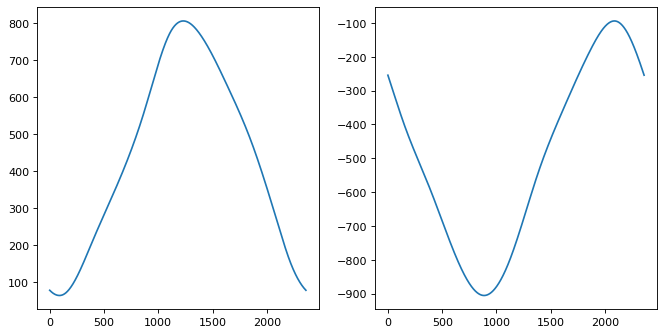

None

<Figure size 432x288 with 0 Axes>

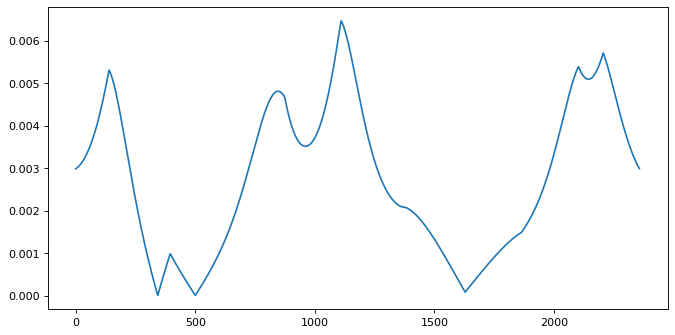

None

In [ ]:
#@title Smoothness and Curve Profile

def cartesian_distance(point1, point2):
    distance = sqrt((point2[1]-point1[1])**2 + (point2[0]-point1[0]) **2)
    return distance

def curvature(p1,p2, p3)-> float:
    return 4 * triang_area(p1,p2,p3)/(dist_2d(p1,p2)*dist_2d(p2,p3)*dist_2d(p1,p3))

def dist_2d(p1,p2)-> float:
    return np.sqrt((p1[0] - p2[0])**2 +(p1[1] - p2[1])**2)

def triang_area(p1, p2, p3):
    return 0.5*np.abs((p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0]-p1[0]))

def find_curvature(spline):
    traj_2D_shifted = []
    flag1 = True
    flag2 = True
    flag3 = True
    curv_list = []
    
    for ind, point in enumerate(spline):

        if ind == 0:
            continue
        if ind == len(spline)-1:
          break
        else:
            curv_list.append(curvature(spline[ind-1], spline[ind], spline[ind+1]))

    return curv_list
  

curv_list = find_curvature(spline_s[:,:2])

smooth_fig = plt.figure()

figure(figsize=(10, 5), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(splinex_s)

plt.subplot(1, 2, 2)
plt.plot(spliney_s)

display(plt.show())


curve_fig = plt.figure()

figure(figsize=(10, 5), dpi=80)

plt.plot(curv_list)

display(plt.show())


In [ ]:
#Sanity check distance between each point

xd = splinex_s
yd = spliney_s

deviate_flag = False

tolerance = 0.03 #meters
target = 1 #meters

for i in range(len(spline_s)-1):
    dd = np.sqrt((xd[i]-xd[i+1])**2 + (yd[i]-yd[i+1])**2)
    if dd>=(target+tolerance) or dd<=(target-tolerance):
      print(f'Deviation of distance detected: {dd}')
      deviate_flag = True

if deviate_flag == False:
  print("Distance between points within expected error")

Distance between points within expected error


# Modify Existing Line

Modifying an existing line is much like generating a new one. Below is simply loading in the csv of the line that you want to modify

In [ ]:
#load in spline
mod_line = pd.read_csv('LVMS_natural_raceline_FIX1_LTP.csv', names=['x', 'y'], header=None, delim_whitespace=True)

#drop the last row since it should be the same as first
mod_line.drop(mod_line.tail(1).index,inplace=True)

#adjust the number of points in the line
mod_line = mod_line[0::10]

Like generating a new line, create the necessary traces you want, make sure that mod_trline and mod_trpath are the last and second last items in the data list.

In [ ]:
#change traces and the 'data' stack accordingly to the lines that want to displayed
mod_tr1 = go.Scatter(x=bound_inner['x'], y=bound_inner['y'], 
                         mode='lines', name='left boundary')

mod_tr2 = go.Scatter(x=bound_outer['x'], y=bound_outer['y'], 
                         mode='lines', name='right boundary')

mod_tr3 = go.Scatter(x=inner_race['x'], y=inner_race['y'], 
                         mode='lines', name='inner race line')

mod_tr4 = go.Scatter(x=natural_race['x'], y=natural_race['y'], 
                         mode='lines', name='natural race line')

mod_tr5 = go.Scatter(x=lvms_centerline['x'], y=lvms_centerline['y'], 
                         mode='lines', name='center line')

mod_trline = go.Scatter(x=mod_line['x'], y=mod_line['y'], name='waypoints')

mod_trpath = go.Scatter(x=xPos, y=yPos, mode='markers', 
                    marker=dict(opacity=0.3), name='path')

data = [mod_tr1, mod_tr2, mod_tr3, mod_tr4, mod_tr5, mod_trpath, mod_trline]



###### No changes need to be made to any of the code below ##########
layout=go.Layout(autosize=False, 
                  width=1000,
                  height=800,
                  template='simple_white')

mod_fig=go.FigureWidget(data=data, layout=layout)

scatter=mod_fig.data[-2] #points that are clickable to generate waypoints
line=mod_fig.data[-1] 
colors=['#a3a7e4']*100
scatter.marker.color=colors
scatter.marker.size=[10]*100
mod_fig.layout.hovermode='closest'

mod_fig.update_traces(marker=dict(line=dict(color='DarkSlateGrey')))

out = widgets.Output(layout={'border': '1px solid black'})
out.append_stdout('Output appended with append_stdout\n')

# create our callback function
@out.capture()
def update_point(trace, points, selector):
    if place_mode.value == 'Extend':
      x = list(line.x) + points.xs
      y = list(line.y) + points.ys
      line.update(x=x, y=y)
      line.mode = 'lines+markers'
    elif place_mode.value == 'Insert':
      xx = points.xs[0]
      yy = points.ys[0]
      idx = closest_point([xx, yy], mod_fig.data[-1]['x'], mod_fig.data[-1]['y'])
      x = list(line.x)
      y = list(line.y)
      x.insert(idx, xx)
      y.insert(idx, yy)
      line.update(x=x, y=y)

scatter.on_click(update_point)


def delete_point(trace, points, selector):
    if len(points.xs)>0:
      x = points.xs[0]
      y = points.ys[0]
      xlist = list(mod_fig.data[-1]['x'])
      ylist = list(mod_fig.data[-1]['y'])
      xlist.remove(x)
      ylist.remove(y)
      line.update(x=xlist, y=ylist)

line.on_click(delete_point)


reset = widgets.Button(description="Reset")
export = widgets.Button(description="Export")

#change between extending line or inserting points onto line
place_mode = widgets.ToggleButtons(
    options = ['Extend', 'Insert'],
    description = 'Point place mode',
    disabled = False,
)

@out.capture()
def on_reset_clicked(b):
    line.update(x=[], y=[])
    out.clear_output()

@out.capture()
def on_export_clicked(b):
    #print(fig.to_dict()["data"][-1]) #uncomment for all trace information
    output.clear()
    print("[X, Y]:")
    for i in range(len(mod_fig.to_dict()["data"][-1]['x'])):
      print(str([mod_fig.to_dict()["data"][-1]['x'][i], mod_fig.to_dict()["data"][-1]['y'][i]]) + ",")

@out.capture()
def on_extend_clicked(b):
  b = 'extend'
  return 'extend'

@out.capture()
def on_insert_clicked(b):
  b = 'insert'
  return 'insert'

reset.on_click(on_reset_clicked)
export.on_click(on_export_clicked)
'''
# Wait for the user to click on an empty area of the plot
click_data = px.click_empty_area(fig)

# Print the x and y coordinates of the clicked point
print(click_data["points"][0]["x"])
print(click_data["points"][0]["y"])
'''

display(widgets.VBox([widgets.HBox([reset, export, place_mode]), widgets.VBox([out])]))
display(mod_fig)

FigureWidget({
    'data': [{'marker': {'line': {'color': 'DarkSlateGrey'}},
              'mode': 'lines',
  …

In [ ]:
#@title Generated Modified Spline

mod_xin = []
mod_yin = []

for i in range(len(mod_fig.to_dict()["data"][-1]['x'])):
  mod_xin.append(mod_fig.to_dict()["data"][-1]['x'][i])
  mod_yin.append(mod_fig.to_dict()["data"][-1]['y'][i])

#mod_xin.append(mod_xin[0])
#mod_yin.append(mod_yin[0])

mod_spline_s, mod_splinex_s, mod_spliney_s = smoother(mod_xin, mod_yin)

mod_fig2 = go.Figure()

mod_fig2.add_trace(go.Scatter(x=bound_inner['x'], y=bound_inner['y'], 
                         mode='lines', name='left boundary'))

mod_fig2.add_trace(go.Scatter(x=bound_outer['x'], y=bound_outer['y'], 
                         mode='lines', name='right boundary'))

mod_fig2.add_trace(go.Scatter(x=inner_race['x'], y=inner_race['y'], 
                         mode='lines', name='old line'))

mod_fig2.add_trace(go.Scatter(x=natural_race['x'], y=natural_race['y'], 
                         mode='lines', name='natural race line'))

mod_fig2.add_trace(go.Scatter(x=lvms_centerline['x'], y=lvms_centerline['y'], 
                         mode='lines', name='center line'))

mod_fig2.add_trace(go.Scatter(x=mod_splinex_s, y=mod_spliney_s, 
                         mode='lines', name='new line'))

mod_fig2.update_layout(
    autosize=False,
    width=1000,
    height=800,
)

mod_fig2.show()

/usr/local/lib/python3.8/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning:

Setting x[0][241]=x[0][0]

/usr/local/lib/python3.8/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning:

Setting x[1][241]=x[1][0]



<Figure size 432x288 with 0 Axes>

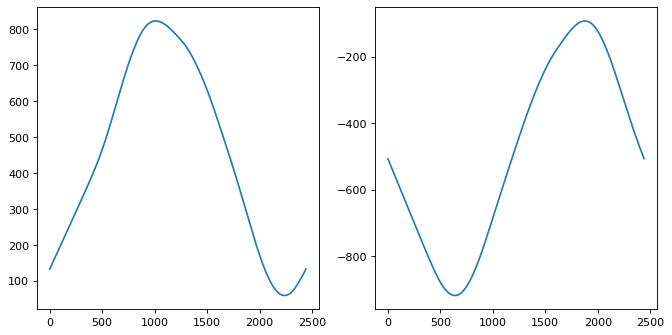

None

<Figure size 432x288 with 0 Axes>

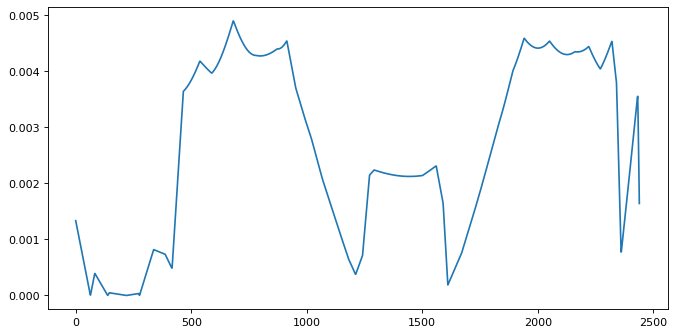

None

In [ ]:
#@title Modified Line Smoothness and Curve Profile

def cartesian_distance(point1, point2):
    distance = sqrt((point2[1]-point1[1])**2 + (point2[0]-point1[0]) **2)
    return distance

def curvature(p1,p2, p3)-> float:
    return 4 * triang_area(p1,p2,p3)/(dist_2d(p1,p2)*dist_2d(p2,p3)*dist_2d(p1,p3))

def dist_2d(p1,p2)-> float:
    return np.sqrt((p1[0] - p2[0])**2 +(p1[1] - p2[1])**2)

def triang_area(p1, p2, p3):
    return 0.5*np.abs((p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0]-p1[0]))

def find_curvature(spline):
    traj_2D_shifted = []
    flag1 = True
    flag2 = True
    flag3 = True
    curv_list = []
    
    for ind, point in enumerate(spline):

        if ind == 0:
            continue
        if ind == len(spline)-1:
          break
        else:
            curv_list.append(curvature(spline[ind-1], spline[ind], spline[ind+1]))

    return curv_list
  

curv_list = find_curvature(mod_spline_s[:,:2])

smooth_fig = plt.figure()

figure(figsize=(10, 5), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(mod_splinex_s)

plt.subplot(1, 2, 2)
plt.plot(mod_spliney_s)

display(plt.show())


curve_fig = plt.figure()

figure(figsize=(10, 5), dpi=80)

plt.plot(curv_list)

display(plt.show())

In [ ]:
#Sanity check distance between each point

xd = mod_splinex_s
yd = mod_spliney_s

deviate_flag = False

for i in range(len(mod_spline_s)-1):
    dd = np.sqrt((xd[i]-xd[i+1])**2 + (yd[i]-yd[i+1])**2)
    if dd>=1.03 or dd<=0.97:
      print(f'Deviation of distance detected: {dd}')
      deviate_flag = True

if deviate_flag == False:
  print("Distance between points within expected error")

Distance between points within expected error


# Export files

Run the code blocks below accordingly on whether or not you generated a new line or modifidied an existing to create the new csv files. Make sure that the name is what you want and that converting to lat-long uses the corresponding LTP file.

## For newly generated lines

In [ ]:
#save LTP version
#change file name accordingly
np.savetxt('LVMS_natural_raceline2PIT_LTP.csv', spline_s, delimiter=" ", fmt='%.17f')

In [ ]:
#save lat-long version
LTP2LLA = convert_latlong('LVMS_natural_raceline2PIT_LTP.csv')
LTP2LLA.to_csv('LVMS_natural_raceline2PIT_LLA.csv', index = False)

#Double check the LLA plots on google earth, there is a chance that X-Y may flipped
#in the conversion

## For modified lines

In [ ]:
#save LTP version
#change file name accordingly
np.savetxt('LVMS_natural_raceline_FIX1_LTP.csv', mod_spline_s, delimiter=" ", fmt='%.17f')

In [ ]:
#save lat-long version
LTP2LLA = convert_latlong('LVMS_natural_raceline_FIX1_LTP.csv')
LTP2LLA.to_csv('LVMS_natural_raceline_FIX1_LLA.csv', index = False)

#Double check the LLA plots on google earth, there is a chance that X-Y may flipped
#in the conversion